# Working Through "Including Systematic Uncertainties in Confidence Interval Construction for Poisson Statistics"
- Cole Kampa
- 11-23-2020
- Paper: https://arxiv.org/abs/hep-ex/0202013v2

# Imports

In [1]:
import time
from copy import deepcopy
import numpy as np
import pandas as pd
from scipy.stats import norm, poisson
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import multiprocessing
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter, FuncFormatter, MultipleLocator
import matplotlib.colors as mcolors

from plot_config import config_plots

In [2]:
config_plots()

# II) The Construction of Confidence Intervals

## B. Conditioning

- Trying to understand equation (5), which modifies probability that accumulates when constructing confidence belt. PDF is conditional--depends on number of observed events $n_0$
- e.g. Suppose $n_0 = 3$, $b=5$

In [8]:
n0 = 3
b = 5
# calculate denominator
denom = np.sum([poisson.pmf(k=nprime,mu=b) for nprime in np.arange(0, n0+1,1)])
# pick an s
s = 1
# loop through n, following conditional eq (5)
ns = np.arange(0, 11, 1)
qs = []
ps = [] # 'normal' probability
for n in ns:
    ps.append(poisson.pmf(k=n, mu=s+b))
    if n <= n0:
        qs.append(poisson.pmf(k=n, mu=s+b) / denom)
    else:
        qs.append(np.sum([poisson.pmf(k=nprime, mu=b)*poisson.pmf(k=n-nprime, mu=s)
                          for nprime in np.arange(0, n0+1,1)]))
ps = np.array(ps)
qs = np.array(qs)

In [9]:
ns

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [10]:
ps

array([0.00247875, 0.01487251, 0.04461754, 0.08923508, 0.13385262,
       0.16062314, 0.16062314, 0.13767698, 0.10325773, 0.06883849,
       0.04130309])

In [11]:
qs

array([9.35286715e-03, 5.61172029e-02, 1.68351609e-01, 3.36703217e-01,
       6.93017796e-02, 3.15214652e-02, 1.00045192e-02, 2.42760332e-03,
       4.75893368e-04, 7.81850678e-05, 1.10494641e-05])

In [12]:
np.argsort(ps)[::-1]

array([ 6,  5,  7,  4,  8,  3,  9,  2, 10,  1,  0])

In [13]:
np.argsort(qs)[::-1]

array([ 3,  2,  4,  1,  5,  6,  0,  7,  8,  9, 10])

In [14]:
np.sum(ps)

0.9573790764174617

In [15]:
np.sum(qs)

0.6843453912640248

- I think I have the algorithm figured out, but the derivation is not clear yet. Think on this more as I continue to read

# Playing Around

- Try: integrating using scipy integration methods or trapezoidal to create F-C bounds that include background uncertainty

In [17]:
from scipy.integrate import quad

In [16]:
b = 2

In [43]:
def q_v1(n, s, b, sigma_b, exp_min=1e-10):
    # given s, b, sigma_b, what is the probability to observe n events?
    if sigma_b == 0:
        return poisson.pmf(k=n, mu=s+b), (False, False)
    prefactor = ((2*np.pi)**(1/2)*sigma_b)**(-1)
    integrand = lambda bprime: poisson.pmf(k=n, mu=s+bprime) * np.exp(-(b-bprime)**2 / (2*sigma_b**2))
    # calculate upper limit to integral, based on exponential minimum
    bp_max = b + (-2*sigma_b**2*np.log(exp_min))**(1/2)
    print(f'integrand @ bp_max = {integrand(bp_max)}')
    res = quad(integrand, 0, bp_max)
    q = prefactor*res[0]
    return q, res

In [45]:
%time q_v1(1, 0, 2, 2*0.5)

integrand @ bp_max = 1.3428448457249954e-13
CPU times: user 10.8 ms, sys: 1.54 ms, total: 12.4 ms
Wall time: 10.9 ms


(0.24172035444349518, (0.6059030750018922, 4.185217978387376e-10))

In [46]:
q_v1(2, 0, 2, 2*0.4), q_v1(2, 0, 2, 0)

integrand @ bp_max = 1.638644845551182e-12


((0.2311946081127787, (0.46361515331017983, 4.713115072697838e-09)),
 (0.2706705664732254, (False, False)))

In [50]:
[(q_v1(n, 0, 2, 2*0.4), q_v1(n, 0, 2, 0)) for n in [0, 1, 2, 3,]]

integrand @ bp_max = 5.938330495133739e-14
integrand @ bp_max = 4.411533669151875e-13
integrand @ bp_max = 1.638644845551182e-12
integrand @ bp_max = 4.057782971075281e-12


[((0.17806813355106102, (0.35708049469588693, 2.9577551806424587e-10)),
  (0.1353352832366127, (False, False))),
 ((0.25619530202427876, (0.5137491103053488, 3.1407494660573576e-11)),
  (0.2706705664732254, (False, False))),
 ((0.2311946081127787, (0.46361515331017983, 4.713115072697838e-09)),
  (0.2706705664732254, (False, False))),
 ((0.15946322010946484, (0.31977201303207303, 5.605446004065817e-09)),
  (0.18044704431548356, (False, False)))]

In [56]:
q_v1(3, 5, 2, 2*0.4)

integrand @ bp_max = 1.2803835311276865e-13


(0.05543733701271087, (0.111168637141047, 3.956499396769869e-11))

# Trying Different Orderings

- Use constructed q_v1 function that integrates over nuisance parameter $b$ to see how UL, CI, F-C intervals change for something like $b=2,3$, and something more realistic to Mu2e $b=0.41$. Compare limits with and without syst. uncertaintiees

In [68]:
# COPIED FROM ABOVE
def q_v1(n, s, b, sigma_b, exp_min=1e-10):
    # given s, b, sigma_b, what is the probability to observe n events?
    if sigma_b == 0:
        return poisson.pmf(k=n, mu=s+b)
    prefactor = ((2*np.pi)**(1/2)*sigma_b)**(-1)
    integrand = lambda bprime: poisson.pmf(k=n, mu=s+bprime) * np.exp(-(b-bprime)**2 / (2*sigma_b**2))
    # calculate upper limit to integral, based on exponential minimum
    bp_max = b + (-2*sigma_b**2*np.log(exp_min))**(1/2)
    #print(f'integrand @ bp_max = {integrand(bp_max)}')
    res = quad(integrand, 0, bp_max)
    q = prefactor*res[0]
    return q

## Upper Limit

$$ P(x<x1|\mu)=1-\alpha\ \ \ \text{(eqn. 2.5, F-C)}$$
- We will use $b=3.0$, as given in the example, and make curves for systematic uncertainties of 0% ("normal"), 20%, 40%
- Note that due to discrete number of observed events $n$, cannot in general satisy exact coverage, so instead opt to avoid undercoverage.

In [78]:
def poisson_classical_UL(s, b=3.0, sigma_b=0, alpha=0.9, exp_min=1e-10):
    # returns x1 that defines minimum x0 for which this particular s is in CL
    pmf_sum = 0
    k = -1
    while pmf_sum <= (1-alpha):
        k += 1
        pmf_sum += q_v1(k, s, b, sigma_b, exp_min)
    return k

In [79]:
poisson_classical_UL(0, b=2, sigma_b=0, alpha=0.9)

0

In [80]:
poisson_classical_UL(5, b=2, sigma_b=0, alpha=0.9)

4

In [100]:
b_ = 2
def poisson_classical_UL_plot(mus=np.linspace(0,15,151), b=b_, sigma_bs=[0, b_*0.4], alpha=0.9, n0=6,
                              xlims=[0,15], ylims=[0,15], exp_min=1e-3):
    # calculates entire UL for poisson+background and plots
    fig, ax = plt.subplots(figsize=(8,8))
    x1_list = []
    n0_ULs = []
    for sigma_b in sigma_bs:
        # calculate x1 for all mus
        x1s = []
        for mu in mus:
            x1s.append(poisson_classical_UL(s=mu, b=b, sigma_b=sigma_b, alpha=alpha, exp_min=exp_min))
        x1s = np.array(x1s)
        x1_list.append(x1s)
        # for example n0, find UL
        idx = (np.abs(n0-x1s)).argmin()
        n0_UL = np.max(mus[x1s==x1s[idx]])
        n0_ULs.append(n0_UL)
        # plot!
        #fig, ax = plt.subplots(figsize=(8,8))
        ax.plot(x1s, mus, linewidth=2, label=rf'U.L. for $\sigma_b = {sigma_b:0.2f}$')
        #ax.fill_betweenx(y1s, x1s, 1.5*xlims[1]*np.ones_like(y1s), label=rf'$\mu$ for which $n_0$ occurs in $\alpha={{alpha}}$ fraction of Experiments')
        ax.fill_betweenx(mus, x1s, 1.5*xlims[1]*np.ones_like(mus), alpha=0.3)#, label=rf'$\mu$ s.t. {alpha*100:.1f}% Experiments for which $n_0$ occurs in $\alpha={{alpha}}$ fraction of Experiments')
    label = rf'e.g. $n_0={n0}$:'+'\n'+\
            ',\n'.join([rf'$\mu_{{\mathrm{{U.L.}}}}={n0_:0.2f} (\sigma_b = {sigma_:0.2f})$'
                         for n0_, sigma_ in zip(n0_ULs, sigma_bs)])
    ax.plot([n0,n0], ylims, 'g--', label=label)
    #ax.plot([n0,n0], ylims, 'g--', label=rf'Particular Experiment: $n_0={n0}, \mu_{{\mathrm{{U.L.}}}}={n0_UL}$')
    # fix tick locations and axis ranges
    ax.set_xticks(np.arange(xlims[0], xlims[1]+1, 1))
    ax.set_yticks(np.arange(ylims[0], ylims[1]+1, 1))
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    # add labels
    ax.set_xlabel(r'Measured $n$')
    ax.set_ylabel(r'Signal Mean $\mu$')
    ax.set_title(rf'Classical {alpha*100:.1f}% C.L. for Poisson Signal+Background (Upper Limit), $b={b}$')
    ax.legend()
    
    return fig, ax, mus, x1s

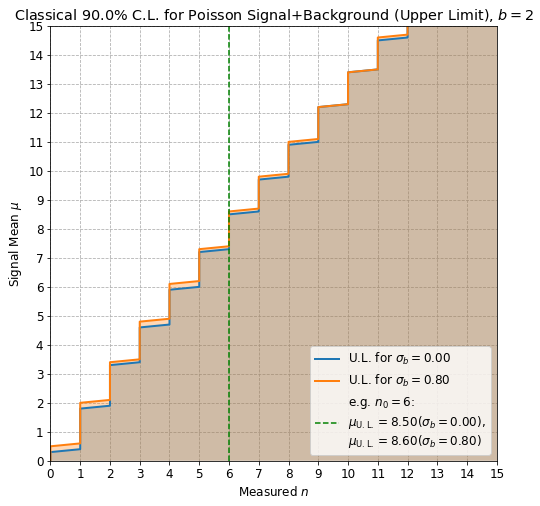

In [101]:
fig, ax, mus, x1s = poisson_classical_UL_plot()

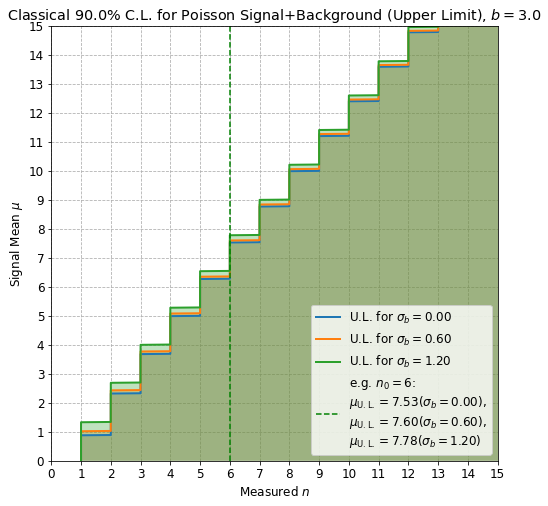

In [109]:
b = 3.0
fig, ax, mus, x1s = poisson_classical_UL_plot(mus=np.linspace(0,15,1501), b=b, sigma_bs=[0, b*0.2, b*0.4],
                                              alpha=0.9, n0=6, xlims=[0,15], ylims=[0,15], exp_min=1e-3)

- This reproduces F.C. Figure 5.
- What does this plot look like for Mu2e? (CD3, $b=0.41 \pm 0.13$ (stat+sys))

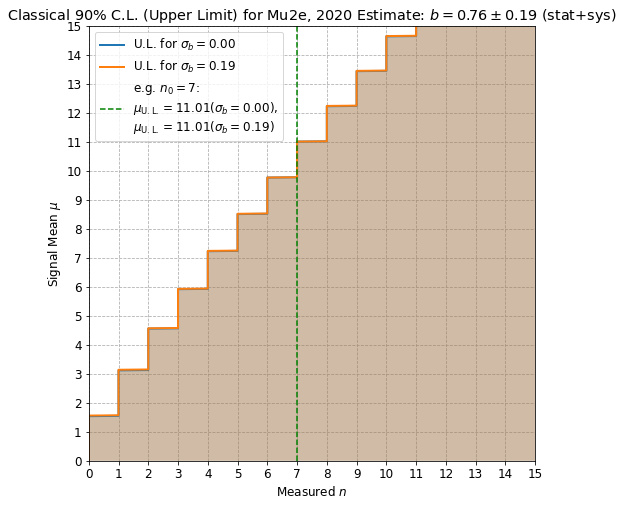

In [108]:
fig, ax, mus, x1s = poisson_classical_UL_plot(mus=np.linspace(0,15,1501), b=0.76, sigma_bs=[0, 0.19], alpha=0.9,
                                              n0=7, xlims=[0,15], ylims=[0,15], exp_min=1e-3)
ax.set_title(rf'Classical 90% C.L. (Upper Limit) for Mu2e, 2020 Estimate: $b={0.76} \pm 0.19$ (stat+sys)');

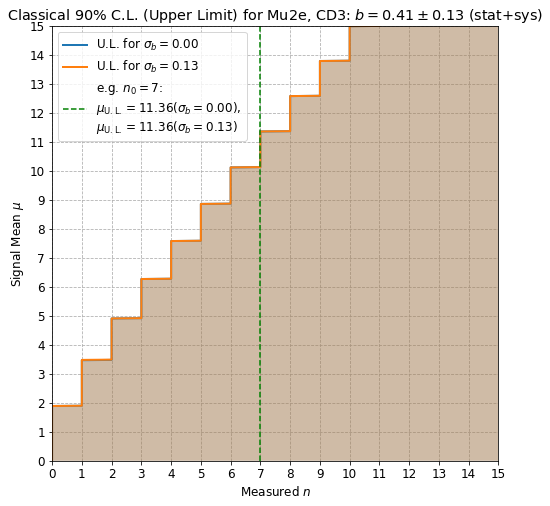

In [110]:
fig, ax, mus, x1s = poisson_classical_UL_plot(mus=np.linspace(0,15,1501), b=0.41, sigma_bs=[0, 0.13], alpha=0.9,
                                              n0=7, xlims=[0,15], ylims=[0,15], exp_min=1e-3)
ax.set_title(rf'Classical 90% C.L. (Upper Limit) for Mu2e, CD3: $b={0.41} \pm 0.13$ (stat+sys)');

- As Michael predicted, it does not appear to make much of a difference, given small $b$ in Mu2e
    - Quote from Conrad paper (section IV.): "Note that for low background expectation the uncertainties in the background can be neglected (see also Table II)."
- Let's convert the Signal Mean $\mu$ to $R_{\mu e}$

In [9]:
def mu2e_mu_to_Rmue(mu=6.63):
    # expected number of signal events scales with R_mu->e, given a fixed signal window and analysis cuts
    s0 = 6.63; Rmue0 = 2e-16; m = Rmue0/s0
    Rmue = m * mu
    return Rmue

In [10]:
def mu2e_mu_to_Rmue_str(x, pos):
    # expected number of signal events scales with R_mu->e, given a fixed signal window and analysis cuts
    s0 = 6.63; Rmue0 = 2e-16; m = Rmue0/s0
    Rmue = m * x
    return f'{Rmue:.2E}'

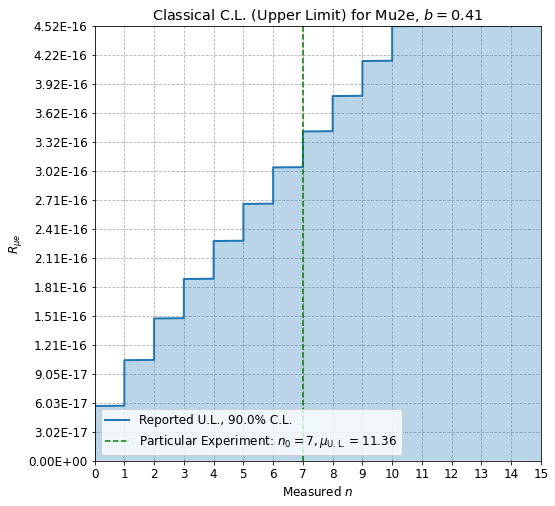

In [11]:
#fig, ax, mus, x1s = poisson_classical_UL_plot(mus=np.linspace(0,15,1501), b=0.41, alpha=0.9,
#                                              n0=7, xlims=[0,15], ylims=[0,15])
ax.set_title(rf'Classical C.L. (Upper Limit) for Mu2e, $b={0.41}$');
yticks = np.arange(0, 16,1)
#ax.set_yticklabels(Rmues,)
fmtr = FuncFormatter(mu2e_mu_to_Rmue_str)
ax.yaxis.set_major_formatter(fmtr)
ax.set_ylabel(r'$R_{\mu e}$');
fig

In [12]:
# SES (Single Event Sensitivity)
mu2e_mu_to_Rmue(1)

3.01659125188537e-17

In [13]:
# BFUL corresponding to plot above (with n0=7)
mu2e_mu_to_Rmue(11.36)

3.42684766214178e-16

In [51]:
6*2*.4

4.800000000000001

In [35]:
np.exp(-(-1)**2 / (2*(2*0.4)**2))

0.4578333617716143

In [23]:
2*.4

0.8

In [40]:
# exp limit
lim = 1e-10
b = 2
sigma_b = b*0.4
bp_max0 = b - (-2*sigma_b**2*np.log(lim))**(1/2)
bp_max1 = b + (-2*sigma_b**2*np.log(lim))**(1/2)
bp_max0, bp_max1

(-3.42891233953209, 7.42891233953209)

In [38]:
np.exp(-(b-bp_max0)**2 / (2*sigma_b**2))

0.0009999999999999994

In [18]:
# quad example
def x2(x):
    return x**2

quad(x2, 0, 4)

(21.333333333333336, 2.368475785867001e-13)

In [20]:
def lin_param(x, a):
    return a*x

quad(lin_param, 0, 1, args=(3,))

(1.5, 1.6653345369377348e-14)

# OLD (F-C)

# Classical Confidence Intervals
"In order to specify uniquely the acceptance region, one must *choose* auxiliary criteria." (pg. 5, paragraph 1)
- Common choices give **upper confidence limits** and **central confidence limits**
- Will reconstruct examples in Section IIIb. Poisson process with background

## Upper Limits

$$ P(x<x1|\mu)=1-\alpha\ \ \ \text{(eqn. 2.5)}$$
- We will use $b=3.0$, as given in the example
- Note that due to discrete number of observed events $n$, cannot in general satisy exact coverage, so instead opt to avoid undercoverage.

In [3]:
def poisson_classical_UL(mu_t, b=3.0, alpha=0.9):
    # returns x1 that defines minimum x0 for which this particular mu_t is in CL
    
    # k range to check
    ks = np.arange(0, 2*(mu_t+b)+1, 1)
    cdfs = poisson.cdf(k=ks, mu=mu_t+b)
    # find first k where cdf > 1-alpha -- avoids undercoverage
    x1 = ks[cdfs > 1-alpha][0]
    return x1

In [4]:
poisson_classical_UL(mu_t=5)

5.0

In [5]:
poisson.sf(4.9, 8)

0.9003675995129541

In [6]:
#def poisson_classical_UL_plot(mus=np.linspace(0,15,151), b=3.0, alpha=0.9, n0=6, xlims=[0,15], ylims=[0,15]):
def poisson_classical_UL_plot(mus=np.linspace(0,15,1501), b=3.0, alpha=0.9, n0=6, xlims=[0,15], ylims=[0,15]):
    # calculates entire UL for poisson+background and plots
    
    # calculate x1 for all mus
    x1s = []
    for mu in mus:
        x1s.append(poisson_classical_UL(mu_t=mu, b=b, alpha=alpha))
    x1s = np.array(x1s)
    
    # for example n0, find UL
    idx = (np.abs(n0-x1s)).argmin()
    n0_UL = np.max(mus[x1s==x1s[idx]])
    
    # plot!
    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(x1s, mus, linewidth=2, label=f'Reported U.L., {alpha*100:.1f}% C.L.')
    #ax.fill_betweenx(y1s, x1s, 1.5*xlims[1]*np.ones_like(y1s), label=rf'$\mu$ for which $n_0$ occurs in $\alpha={{alpha}}$ fraction of Experiments')
    ax.fill_betweenx(mus, x1s, 1.5*xlims[1]*np.ones_like(mus), alpha=0.3)#, label=rf'$\mu$ s.t. {alpha*100:.1f}% Experiments for which $n_0$ occurs in $\alpha={{alpha}}$ fraction of Experiments')
    ax.plot([n0,n0], ylims, 'g--', label=rf'Particular Experiment: $n_0={n0}, \mu_{{\mathrm{{U.L.}}}}={n0_UL}$')
    # fix tick locations and axis ranges
    ax.set_xticks(np.arange(xlims[0], xlims[1]+1, 1))
    ax.set_yticks(np.arange(ylims[0], ylims[1]+1, 1))
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    # add labels
    ax.set_xlabel(r'Measured $n$')
    ax.set_ylabel(r'Signal Mean $\mu$')
    ax.set_title(rf'Classical C.L. for Poisson Signal+Background (Upper Limit), $b={b}$')
    ax.legend()
    
    return fig, ax, mus, x1s

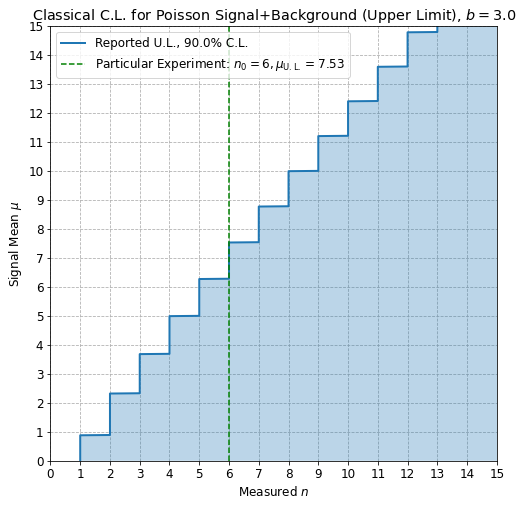

In [7]:
fig, ax, mus, x1s = poisson_classical_UL_plot()

- This reproduces F.C. Figure 5.
- What does this plot look like for Mu2e?

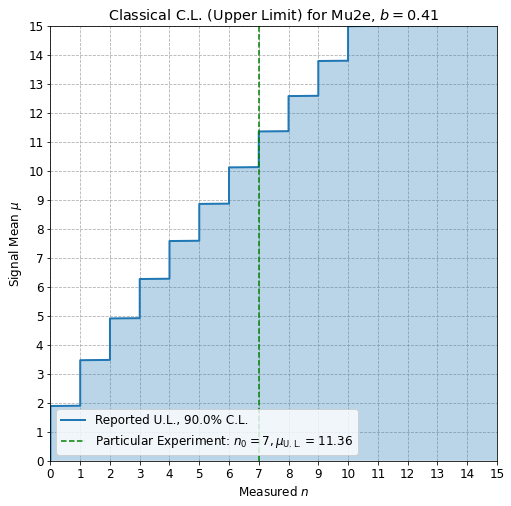

In [8]:
fig, ax, mus, x1s = poisson_classical_UL_plot(mus=np.linspace(0,15,1501), b=0.41, alpha=0.9,
                                              n0=7, xlims=[0,15], ylims=[0,15])
ax.set_title(rf'Classical C.L. (Upper Limit) for Mu2e, $b={0.41}$');

- Let's convert the Signal Mean $\mu$ to $R_{\mu e}$

In [9]:
def mu2e_mu_to_Rmue(mu=6.63):
    # expected number of signal events scales with R_mu->e, given a fixed signal window and analysis cuts
    s0 = 6.63; Rmue0 = 2e-16; m = Rmue0/s0
    Rmue = m * mu
    return Rmue

In [10]:
def mu2e_mu_to_Rmue_str(x, pos):
    # expected number of signal events scales with R_mu->e, given a fixed signal window and analysis cuts
    s0 = 6.63; Rmue0 = 2e-16; m = Rmue0/s0
    Rmue = m * x
    return f'{Rmue:.2E}'

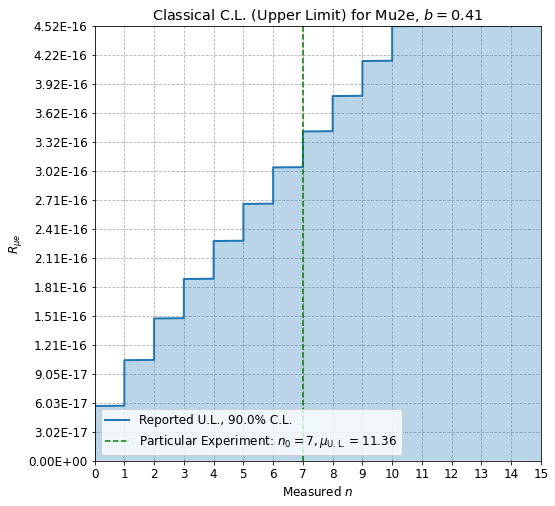

In [11]:
#fig, ax, mus, x1s = poisson_classical_UL_plot(mus=np.linspace(0,15,1501), b=0.41, alpha=0.9,
#                                              n0=7, xlims=[0,15], ylims=[0,15])
ax.set_title(rf'Classical C.L. (Upper Limit) for Mu2e, $b={0.41}$');
yticks = np.arange(0, 16,1)
#ax.set_yticklabels(Rmues,)
fmtr = FuncFormatter(mu2e_mu_to_Rmue_str)
ax.yaxis.set_major_formatter(fmtr)
ax.set_ylabel(r'$R_{\mu e}$');
fig

In [12]:
# SES (Single Event Sensitivity)
mu2e_mu_to_Rmue(1)

3.01659125188537e-17

In [13]:
# BFUL corresponding to plot above (with n0=7)
mu2e_mu_to_Rmue(11.36)

3.42684766214178e-16

## Central Intervals

$$ P(x<x1|\mu)= P(x>x2|\mu) = (1-\alpha)/2\ \ \ \text{(eqn. 2.6)}$$
- We will use $b=3.0$, as given in the example
- Note that due to discrete number of observed events $n$, cannot in general satisy exact coverage, so instead opt to avoid undercoverage.

**FIXME: TRY USING poisson.isf and poisson.cdf**

In [14]:
def poisson_classical_central(mu_t, b=3.0, alpha=0.9):
    # returns x1, x2 that defines central acceptance region for this particular mu_t is in CL
    
    # k range to check
    ks = np.arange(0, 5*(mu_t+b)+1, 1)
    cdfs = poisson.cdf(k=ks, mu=mu_t+b) # for x1
    sfs = poisson.sf(k=ks, mu=mu_t+b) # for x2
    
    # find first k where cdf > (1-alpha)/2 -- avoids undercoverage
    x1 = ks[cdfs > (1-alpha)/2][0]
    # find first k where sf < (1-alpha)/2
    x2 = ks[sfs < (1-alpha)/2][0]
    return x1, x2

In [15]:
poisson_classical_central(5)

(4.0, 13.0)

In [16]:
poisson.cdf(13, 8)-poisson.cdf(3.9, 8)

0.9234391862144967

In [17]:
#def poisson_classical_UL_plot(mus=np.linspace(0,15,151), b=3.0, alpha=0.9, n0=6, xlims=[0,15], ylims=[0,15]):
def poisson_classical_central_plot(mus=np.linspace(0,15,1501), b=3.0, alpha=0.9, n0=6, xlims=[0,15], ylims=[0,15]):
    # calculates entire UL for poisson+background and plots
    
    # calculate x1 for all mus
    x1s = []
    x2s = []
    for mu in mus:
        x1_, x2_ = poisson_classical_central(mu_t=mu, b=b, alpha=alpha)
        x1s.append(x1_)
        x2s.append(x2_)
    x1s = np.array(x1s)
    x2s = np.array(x2s)
    
    # for example n0, find UL
    idx = (np.abs(n0-x1s)).argmin()
    if (x2s==x1s[idx]).sum() < 1:
        n0_CL0 = 0
    else:
        n0_CL0 = np.min(mus[x2s==x1s[idx]])
    n0_CL1 = np.max(mus[x1s==x1s[idx]])
    
    # plot!
    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(x1s, mus, color='blue', linewidth=2, )#label=f'Reported U.L., {alpha*100:.1f}% C.L.')
    ax.plot(x2s, mus, color='blue', linewidth=2, )
    #ax.fill_betweenx(y1s, x1s, 1.5*xlims[1]*np.ones_like(y1s), label=rf'$\mu$ for which $n_0$ occurs in $\alpha={{alpha}}$ fraction of Experiments')
    ax.fill_betweenx(mus, x1s, x2s, alpha=0.3, label=f'{alpha*100:.1f}% C.I.')#, label=rf'$\mu$ s.t. {alpha*100:.1f}% Experiments for which $n_0$ occurs in $\alpha={{alpha}}$ fraction of Experiments')
    ax.plot([n0,n0], ylims, 'g--', label=rf'Particular Experiment: $n_0={n0}, \mu_{{\ \mathrm{{C.I.}}}}=[{n0_CL0}, {n0_CL1}]$')
    # fix tick locations and axis ranges
    ax.set_xticks(np.arange(xlims[0], xlims[1]+1, 1))
    ax.set_yticks(np.arange(ylims[0], ylims[1]+1, 1))
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    # add labels
    ax.set_xlabel(r'Measured $n$')
    ax.set_ylabel(r'Signal Mean $\mu$')
    ax.set_title(rf'Classical C.L. for Poisson Signal+Background (Central Interval), $b={b}$')
    ax.legend()
    
    return fig, ax, mus, x1s, x2s

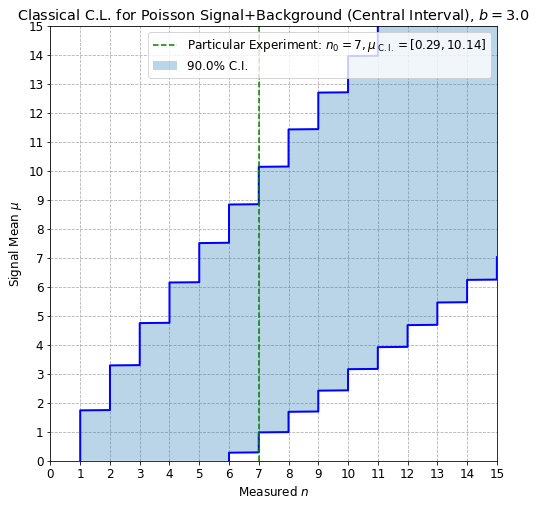

In [18]:
fig, ax, mus, x1s, x2s = poisson_classical_central_plot(n0=7)

- This reproduces F.C. Figure 6.
- What does this plot look like for Mu2e?

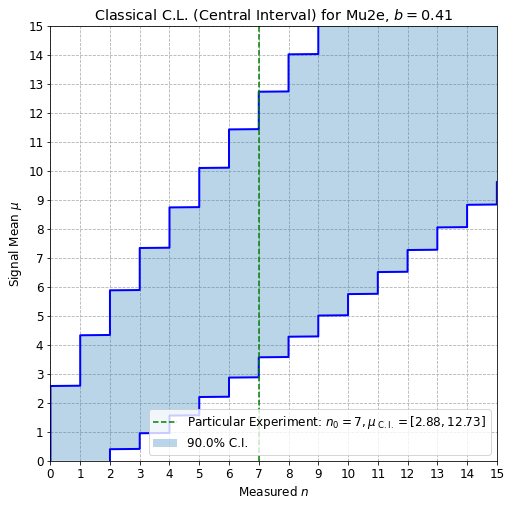

In [19]:
fig, ax, mus, x1s, x2s = poisson_classical_central_plot(mus=np.linspace(0,15,1501), b=0.41, alpha=0.9,
                                                        n0=7, xlims=[0,15], ylims=[0,15])
ax.set_title(rf'Classical C.L. (Central Interval) for Mu2e, $b={0.41}$');

- Let's convert the Signal Mean $\mu$ to $R_{\mu e}$

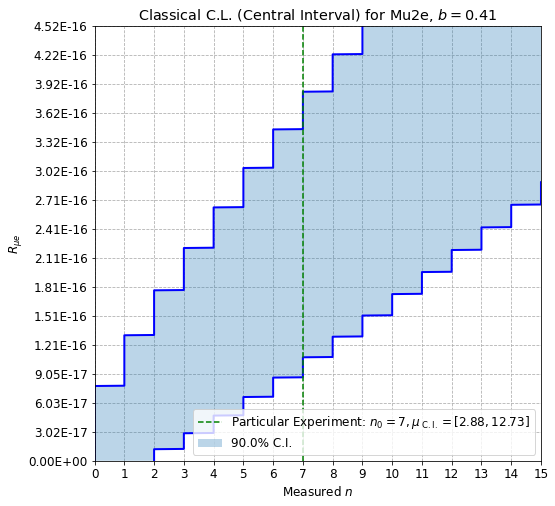

In [22]:
#fig, ax, mus, x1s, x2s = poisson_classical_central_plot(mus=np.linspace(0,15,1501), b=0.41, alpha=0.9,
#                                                        n0=7, xlims=[0,15], ylims=[0,15])
ax.set_title(rf'Classical C.L. (Central Interval) for Mu2e, $b={0.41}$');
yticks = np.arange(0, 16,1)
#ax.set_yticklabels(Rmues,)
fmtr = FuncFormatter(mu2e_mu_to_Rmue_str)
ax.yaxis.set_major_formatter(fmtr)
ax.set_ylabel(r'$R_{\mu e}$');
fig

In [23]:
# R_mue CL corresponding to plot above (with n0=7)
mu2e_mu_to_Rmue(2.88), mu2e_mu_to_Rmue(12.73)

(8.687782805429864e-17, 3.8401206636500756e-16)

# Feldman-Cousins Ordering

## Poisson Signal+ Background

### Reproduce Table I.
- This is an example of constructing the acceptance band (horizontal), for a specific $\mu=0.5$, given $b=3.0$

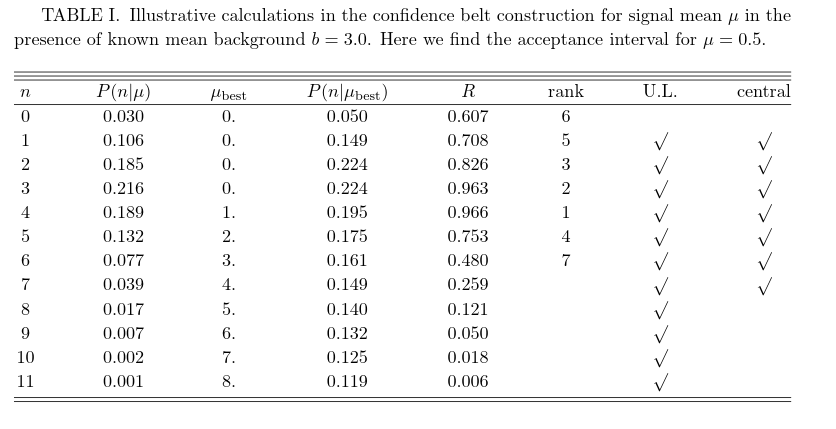

In [90]:
def FC_Poisson_Table(ns=np.arange(0,12,1), mu=0.5, b=3.0, alpha=0.9):
    Ps = []
    mus_best = []
    Ps_best = []
    #Rs = []
    for n in ns:
        mu_best = max(0, n-b)
        P = poisson.pmf(n, mu+b)
        P_best = poisson.pmf(n, mu_best+b)
        mus_best.append(mu_best)
        Ps.append(P)
        Ps_best.append(P_best)
    Ps = np.array(Ps)
    mus_best = np.array(mus_best)
    Ps_best = np.array(Ps_best)
    Rs = Ps / Ps_best # FC statistic (likelihood ratio)
    temp = Rs.argsort()[::-1]
    ranks = temp.argsort() + 1
    Ps_sorted = Ps[Rs.argsort()[::-1]]
    prob = 0.
    i = 0
    while prob <= alpha:
        prob+=Ps_sorted[i]
        i += 1
    mus_acc = ns[Rs.argsort()[::-1][:i]]
    df = pd.DataFrame({r'$n$':ns, r'$P(n|\mu)$': Ps, r'$\mu_{\mathrm{best}}$':mus_best,
                       r'$P(n|\mu_{\mathrm{best}})$':Ps_best, r'$R$':Rs, 'rank': ranks})
    return df, mus_acc
    #return ns, Ps, mus_best, Ps_best, Rs, ranks

In [91]:
df, mus_acc = FC_Poisson_Table()

In [92]:
mus_acc

array([4, 3, 2, 5, 1, 0, 6])

In [89]:
df

,$n$,$P(n|\mu)$,$\mu_{\mathrm{best}}$,$P(n|\mu_{\mathrm{best}})$,$R$,rank
0,0,0.030197,0.0,0.049787,0.606531,6
1,1,0.105691,0.0,0.149361,0.707619,5
2,2,0.184959,0.0,0.224042,0.825556,3
3,3,0.215785,0.0,0.224042,0.963148,2
4,4,0.188812,1.0,0.195367,0.966450,1
5,5,0.132169,2.0,0.175467,0.753237,4
6,6,0.077098,3.0,0.160623,0.479995,7
7,7,0.038549,4.0,0.149003,0.258714,8
8,8,0.016865,5.0,0.139587,0.120823,9
9,9,0.006559,6.0,0.131756,0.049779,10


### Full Construction

In [314]:
def FC_Poisson_Acceptance(mu=0.5, b=3.0, alpha=0.9):
    #ns = np.arange(0, max(10,int(5*(mu+b))), 1)
    lam = mu+b
    n0 = int(max(0, lam/2-10))
    nf = int(3/2*lam + 10)
    #n0 = int(max(0, 1/4*lam))
    #nf = int(7/4*lam)
    ns = np.arange(n0, nf+1, 1)
    Ps = []
    mus_best = []
    Ps_best = []
    #Rs = []
    for n in ns:
        mu_best = max(0, n-b)
        P = poisson.pmf(n, mu+b)
        P_best = poisson.pmf(n, mu_best+b)
        mus_best.append(mu_best)
        Ps.append(P)
        Ps_best.append(P_best)
    Ps = np.array(Ps)
    mus_best = np.array(mus_best)
    Ps_best = np.array(Ps_best)
    Rs = Ps / Ps_best # FC statistic (likelihood ratio)
    temp = Rs.argsort()[::-1]
    #ranks = temp.argsort() + 1
    Ps_sorted = Ps[temp]
    prob = 0.
    i = 0
    while prob <= alpha:
        prob+=Ps_sorted[i]
        i += 1
    mus_acc = ns[temp[:i]]
    n1 = np.min(mus_acc)
    n2 = np.max(mus_acc)
    return n1, n2

In [315]:
%time n1, n2 = FC_Poisson_Acceptance()

CPU times: user 217 µs, sys: 5.47 ms, total: 5.69 ms
Wall time: 4.95 ms


In [316]:
def FC_Poisson_Construct_Plot(mus=np.linspace(0,15,751), b=3.0, alpha=0.9, xlims=[0,15], ylims=[0,15]):
    n1s = []
    n2s = []
    for mu in mus:
        n1_, n2_ = FC_Poisson_Acceptance(mu=mu, b=b, alpha=alpha)
        n1s.append(n1_)
        n2s.append(n2_)
    n1s = np.array(n1s)
    n2s = np.array(n2s)
    
    # for example n0, find UL
    '''
    idx = (np.abs(n0-x1s)).argmin()
    if (x2s==x1s[idx]).sum() < 1:
        n0_CL0 = 0
    else:
        n0_CL0 = np.min(mus[x2s==x1s[idx]])
    n0_CL1 = np.max(mus[x1s==x1s[idx]])
    '''
    
    # plot!
    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(n1s, mus, color='blue', linewidth=2, )#label=f'Reported U.L., {alpha*100:.1f}% C.L.')
    ax.plot(n2s, mus, color='blue', linewidth=2, )
    #ax.fill_betweenx(y1s, x1s, 1.5*xlims[1]*np.ones_like(y1s), label=rf'$\mu$ for which $n_0$ occurs in $\alpha={{alpha}}$ fraction of Experiments')
    ax.fill_betweenx(mus, n1s, n2s, alpha=0.3, label=f'{alpha*100:.1f}% C.I.')#, label=rf'$\mu$ s.t. {alpha*100:.1f}% Experiments for which $n_0$ occurs in $\alpha={{alpha}}$ fraction of Experiments')
    ###ax.plot([n0,n0], ylims, 'g--', label=rf'Particular Experiment: $n_0={n0}, \mu_{{\ \mathrm{{C.I.}}}}=[{n0_CL0}, {n0_CL1}]$')
    # fix tick locations and axis ranges
    ax.set_xticks(np.arange(xlims[0], xlims[1]+1, 1))
    ax.set_yticks(np.arange(ylims[0], ylims[1]+1, 1))
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    # add labels
    ax.set_xlabel(r'Measured $n$')
    ax.set_ylabel(r'Signal Mean $\mu$')
    ax.set_title(rf'Feldman-Cousins C.L. for Poisson Signal+Background, $b={b}$')
    ax.legend()
    
    return fig, ax, mus, n1s, n2s

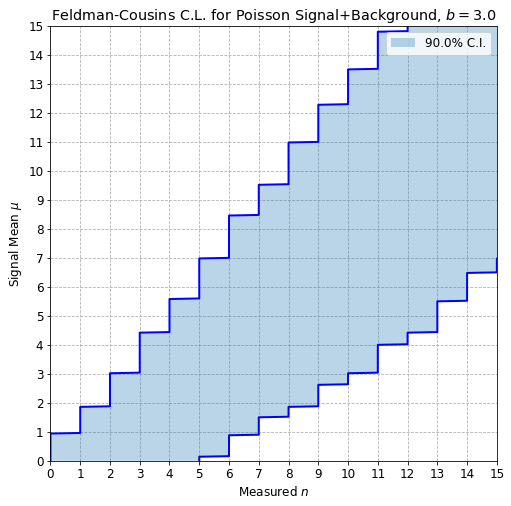

In [133]:
fig, ax, mus, n1s, n2s = FC_Poisson_Construct_Plot()

- This reproduces F.C. Figure 7.
- What does this plot look like for Mu2e?

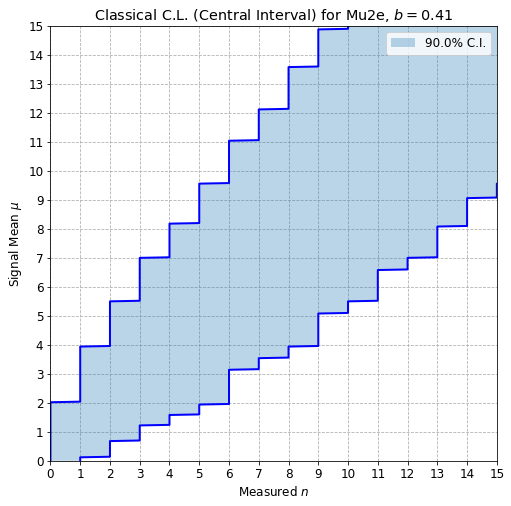

In [134]:
fig, ax, mus, n1s, n2s = FC_Poisson_Construct_Plot(b=0.41)
ax.set_title(rf'Classical C.L. (Central Interval) for Mu2e, $b={0.41}$');

- Let's convert the Signal Mean $\mu$ to $R_{\mu e}$

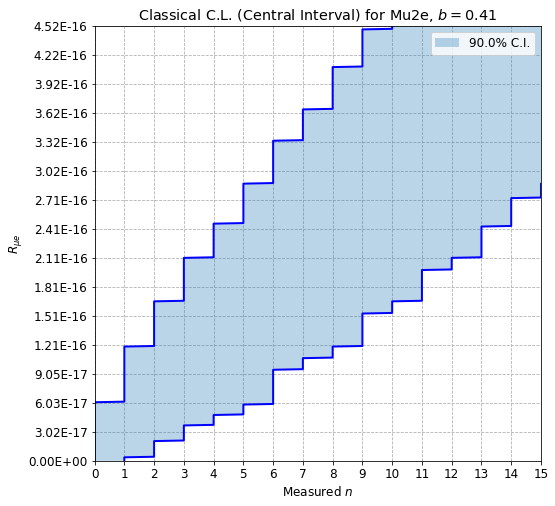

In [135]:
#fig, ax, mus, n1s, n2s = FC_Poisson_Construct_Plot(b=0.41)
ax.set_title(rf'Classical C.L. (Central Interval) for Mu2e, $b={0.41}$');
yticks = np.arange(0, 16,1)
#ax.set_yticklabels(Rmues,)
fmtr = FuncFormatter(mu2e_mu_to_Rmue_str)
ax.yaxis.set_major_formatter(fmtr)
ax.set_ylabel(r'$R_{\mu e}$');
fig

### Confidence Band Endpoints vs. Mean Expected Background b

In [343]:
def FC_Poisson_Acceptance_v2(mu=0.5, b=3.0, alpha=0.9):
    #ns = np.arange(0, max(10,int(5*(mu+b))), 1)
    lam = mu+b
    n0 = int(max(0, lam/2-10))
    nf = int(3/2*lam + 10)
    #print(n0, nf)
    #n0 = int(max(0, 1/4*lam))
    #nf = int(7/4*lam)
    ns = np.arange(n0, nf+1, 1)
    Ps = []
    mus_best = []
    Ps_best = []
    #Rs = []
    for n in ns:
        mu_best = max(0, n-b)
        P = poisson.pmf(n, mu+b)
        P_best = poisson.pmf(n, mu_best+b)
        mus_best.append(mu_best)
        Ps.append(P)
        Ps_best.append(P_best)
    Ps = np.array(Ps)
    mus_best = np.array(mus_best)
    Ps_best = np.array(Ps_best)
    Rs = Ps / Ps_best # FC statistic (likelihood ratio)
    temp = Rs.argsort()[::-1]
    #ranks = temp.argsort() + 1
    Ps_sorted = Ps[temp]
    prob = 0.
    i = 0
    while prob <= alpha:
        prob+=Ps_sorted[i]
        i += 1
    mus_acc = ns[temp[:i]]
    n1 = np.min(mus_acc)
    n2 = np.max(mus_acc)
    return n1, n2

In [358]:
def FC_Poisson_ns_CL_v2(ns=np.arange(0,11,1), b=3.0, alpha=0.9, eps=0.01):
#def FC_Poisson_ns_CL_v2(ns=np.arange(7,8,1), b=3.0, alpha=0.9):
    #eps = 0.01
    # find minimum n that gives LL > 0.
    min_n_LL = FC_Poisson_Acceptance_v2(mu=0, b=b, alpha=alpha)[1]
    #print(min_n_LL)
    
    ULs = []
    LLs = []
    
    for n in ns:
        #print(f'Starting n={n}')
        if n <= min_n_LL:
            #print('LL=0')
            LLs.append(0)
        else:
            target0 = n-1
            #target1 = n
            mu_ = 0
            s = 1
            flipped = False
            delta = 1
            n2 = -1000
            while (delta>=eps):
            #while (abs(n2-n) > 1e-2):
                mu_ += delta*s
                #print(mu_)
                #if mu_+b < 0:
                #    mu_=-b
                ## FIXME -- I think I need to use n1 in the case of small n
                try:
                    _, n2 = FC_Poisson_Acceptance(mu=mu_, b=b, alpha=alpha)
                except:
                    n2 = n
                    mu_ = 0
                
                if n2 <= target0:
                    s_ = 1
                else:
                    s_ = -1
                if s_!=s:
                    flipped=True
                s = s_
                if flipped:
                    #s *= -1
                    delta *= 0.1
                    flipped = False
            if n2!=n:
                mu_ += delta
            LLs.append(mu_)
        mu1_ = LLs[-1]
        target1 = n
        s = 1
        flipped = False
        delta = 1
        n1 = -1000
        while (delta>=eps):
        #while (abs(n2-n) > 1e-2):
            mu1_ += delta*s
            n1, _ = FC_Poisson_Acceptance(mu=mu1_, b=b, alpha=alpha)

            if n1 <= target1:
                s_ = 1
            else:
                s_ = -1
            if s_!=s:
                flipped=True
            s = s_
            if flipped:
                #s *= -1
                delta *= 0.1
                flipped = False
        if n1!=n:
            mu1_ -= delta
        ULs.append(mu1_)
        
    LLs = np.array(LLs)
    ULs = np.array(ULs)
    
    return ns, LLs, ULs

In [359]:
%time ns, LLs, ULs = FC_Poisson_ns_CL_v2()

CPU times: user 721 ms, sys: 3.5 ms, total: 724 ms
Wall time: 722 ms


In [360]:
ns, LLs, ULs

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.16, 0.9 , 1.51, 1.88, 2.64]),
 array([ 0.959,  1.879,  3.039,  4.429,  5.599,  6.989,  8.469,  9.539,
        10.999, 12.299, 13.509]))

In [482]:
#def FC_Poisson_ns_CL_b_range(ns=np.arange(0,11,1), bs=np.arange(0,20+0.1,0.1), alpha=0.9):
#def FC_Poisson_ns_CL_b_range(ns=np.arange(0,11,1), bs=np.arange(0,20+0.5,0.5), alpha=0.9):
##def FC_Poisson_ns_CL_b_range(ns=np.arange(4,11,1), bs=np.arange(0,2.5+0.1,0.1), alpha=0.9):
def FC_Poisson_ns_CL_b_range(ns=np.arange(0,11,1), bs=np.arange(0,2.5+0.1,0.1), alpha=0.9):
#def FC_Poisson_ns_CL_b_range(ns=np.arange(10,11,1), bs=np.arange(0,20+1,1), alpha=0.9):
    LLs = []
    ULs = []
    for b in bs:
        _, LLs_, ULs_ = FC_Poisson_ns_CL_v2(ns=ns, b=b, alpha=alpha)
        LLs.append(LLs_)
        ULs.append(ULs_)
    LLs = np.array(LLs).T
    ULs = np.array(ULs).T
    return ns, bs, LLs, ULs

In [368]:
#%time ns, bs, LLs, ULs = FC_Poisson_ns_CL_b_range()

CPU times: user 20.7 s, sys: 10.6 ms, total: 20.7 s
Wall time: 20.7 s


In [452]:
%time ns, bs, LLs, ULs = FC_Poisson_ns_CL_b_range(ns=np.arange(0,11,1), bs=np.arange(0,20+0.1, 0.1), alpha=0.9)

CPU times: user 2min 16s, sys: 3.49 s, total: 2min 19s
Wall time: 2min 15s


In [457]:
LLs[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [458]:
LLs[2]

array([0.54, 0.44, 0.34, 0.24, 0.14, 0.04, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

In [462]:
def plot_ULs_vs_bg(ns, bs, ULs, LLs, enforce_monotone=True, xlims=[0,20], ylims=[0,20]):
    # get 10 colors
    cdict = deepcopy(mcolors.TABLEAU_COLORS)
    cdict['black'] = (0, 0, 0)
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    #l = ax.plot([0],[0], alpha=0, color='w', label='Events Observed')
    # loop through all n
    for n, UL, LL, color in zip(ns, ULs, LLs, cdict.keys()):
        # force UL to be monotonically decreasing
        if enforce_monotone:
            #UL_ = np.minimum.accumulate(UL)
            UL_ = np.maximum.accumulate(UL[::-1])[::-1]
        else:
            UL_ = UL
        # check where LL == 0
        noLLmap = (LL == 0)
        # find unlikely n
        p_n_or_less = poisson.cdf(n, bs)
        unlikely_map = (p_n_or_less < 0.01) # <1% of pdf in n or less
        #LLmap = (LL > 0)
        # plot region with LL
        if np.sum(~noLLmap) > 0:
            ax.plot(bs[~noLLmap], UL_[~noLLmap], linestyle='dotted', color=color)#, label=f'{n}')
        # plot unlikely measurements
        if np.sum(unlikely_map > 0):
            ax.plot(bs[unlikely_map], UL_[unlikely_map], linestyle='dashed', color=color)
        # plot likely region with LL = 0
        ax.plot(bs[(noLLmap)&(~unlikely_map)], UL_[(noLLmap)&(~unlikely_map)], color=color, label=f'{n}')
    
    ax.set_xticks(np.arange(xlims[0], xlims[1]+1, 5))
    ax.set_yticks(np.arange(ylims[0], ylims[1]+1, 5))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    # add labels
    ax.set_xlabel('Mean Expeced Background b')
    ax.set_ylabel(r'Upper end of conf. int. for $\mu$')
    ax.set_title(rf'Feldman-Cousins U.L. vs. b for Poisson Signal+Background')
    ax.legend(title=r'Events Observed ($n_0$)', bbox_to_anchor=(1.05, 1), loc='upper left')
    #plt.legend(bbox_to_anchor(1.05, 1), loc='upper left')

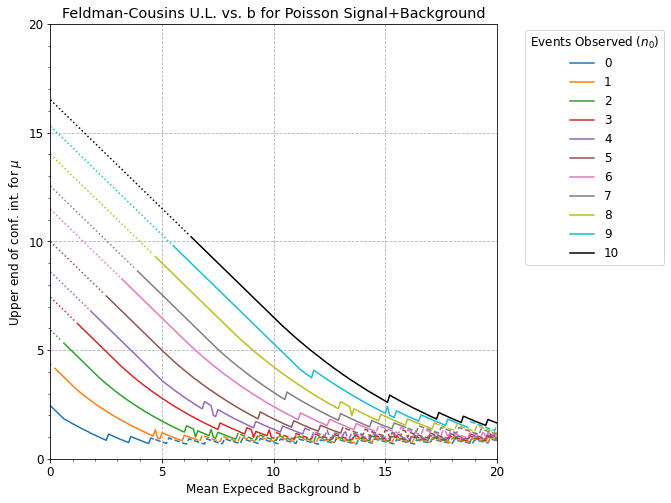

In [463]:
plot_ULs_vs_bg(ns, bs, ULs, LLs, enforce_monotone=False)

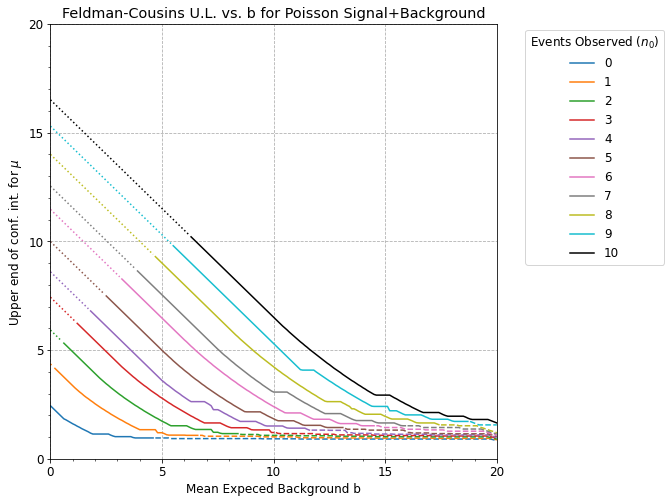

In [464]:
plot_ULs_vs_bg(ns, bs, ULs, LLs, enforce_monotone=True)

- The dotted regions indicate where the LL of the interval is >0.
- The dashed regions indicate measurements that are very unlikely (<1%, given $\mu=0$)
- This nearly reproduces Fig. 8. See for e.g. $n_0 = 1$, near $b=5$, not exactly the same.
    - Best guess (without thinking about it too much) is that this is based on the resolution of $b$ that I used is much coarser than in FC. They quote scanning with step size $\Delta b = 0.001$ (and sometimes smaller), and I use $\Delta b = 0.1$ due to computation time.

In [472]:
def plot_LLs_vs_bg(ns, bs, ULs, LLs, enforce_monotone=True, xlims=[0,20], ylims=[0,20]):
    # get 10 colors
    cdict = deepcopy(mcolors.TABLEAU_COLORS)
    cdict['black'] = (0, 0, 0)
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    #l = ax.plot([0],[0], alpha=0, color='w', label='Events Observed')
    # loop through all n
    for n, UL, LL, color in zip(ns, ULs, LLs, cdict.keys()):
        # force UL to be monotonically decreasing
        if enforce_monotone:
            #UL_ = np.minimum.accumulate(UL)
            LL_ = np.maximum.accumulate(LL[::-1])[::-1]
        else:
            LL_ = LL
        # check where LL == 0
        LLmap = (LL_ > 0)
        if np.sum(LLmap) > 0:
            ax.plot(bs[LLmap], LL_[LLmap], color=color, label=f'{n}')
    ax.set_xticks(np.arange(xlims[0], xlims[1]+1, 5))
    ax.set_yticks(np.arange(ylims[0], ylims[1]+1, 5))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    # add labels
    ax.set_xlabel('Mean Expeced Background b')
    ax.set_ylabel(r'Lower end of conf. int. for $\mu$')
    ax.set_title(rf'Feldman-Cousins L.L. vs. b for Poisson Signal+Background')
    ax.legend(title=r'Events Observed ($n_0$)', bbox_to_anchor=(1.05, 1), loc='upper left')
    #plt.legend(bbox_to_anchor(1.05, 1), loc='upper left')

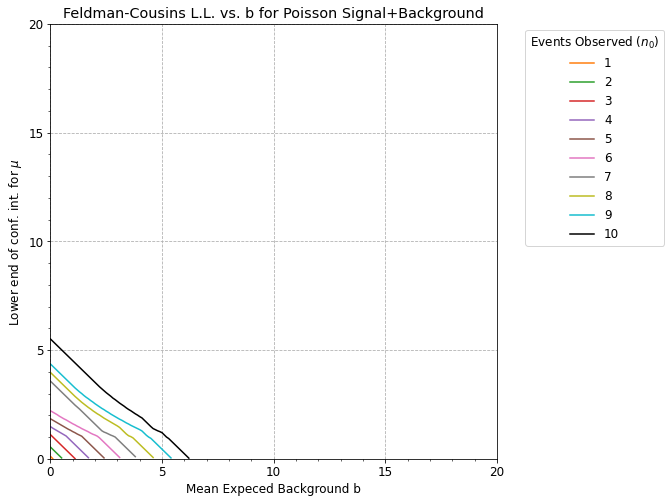

In [473]:
plot_LLs_vs_bg(ns, bs, ULs, LLs, enforce_monotone=False)

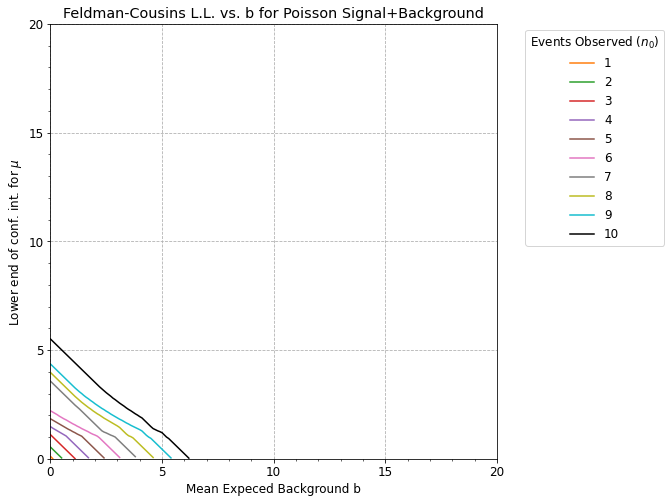

In [469]:
plot_LLs_vs_bg(ns, bs, ULs, LLs, enforce_monotone=True)

- This reproduces Fig. 9. Not sure if monotone condition changes anything in this case. Also not sure if this condition must be enforced for the LL. 

### Parallelize
- Should be able to run calculation on 64 simulatneous threads
- Will make it reasonable to get closer to FC plot with fine spacing in b

In [501]:
def FC_Poisson_ns_CL_b_range_parallel(ns=np.arange(0,11,1), bs=np.arange(0,2.5+0.1,0.1), alpha=0.9):
    print('Calculating Limits vs. Expected Background')
    print('------------------------------------------')
    start = time.time()
    num_cpu = multiprocessing.cpu_count()
    print(f'CPU Threads: {num_cpu}')
    limit_tuples = Parallel(n_jobs=num_cpu)(delayed(FC_Poisson_ns_CL_v2)
                                            (ns=ns, b=b, alpha=alpha) for b in tqdm(bs, desc='b', total=len(bs)))
    LLs = np.array([i[1] for i in limit_tuples]).T
    ULs = np.array([i[2] for i in limit_tuples]).T
    
    stop = time.time()
    print(f'Runtime: {stop-start} s, {(stop-start)/60.} min')
    
    return ns, bs, LLs, ULs

In [489]:
# testing
ns, bs, LLs, ULs = FC_Poisson_ns_CL_b_range_parallel()

Calculating Limits vs. Expected Background
------------------------------------------
CPU Threads: 64



Runtime: 1.1873443126678467 s, 0.019789071877797444 min


In [490]:
# full b resolution (0.001)
ns, bs, LLs, ULs = FC_Poisson_ns_CL_b_range_parallel(ns=np.arange(0,11,1), bs=np.arange(0,20+0.001, 0.001), alpha=0.9)

Calculating Limits vs. Expected Background
------------------------------------------
CPU Threads: 64



Runtime: 399.4833450317383 s, 6.6580557505289715 min


In [493]:
bs.shape

(20001,)

In [499]:
LLs.shape

(20001, 11)

In [502]:
# fix for first calculation
#LLs = LLs.T
#ULs = ULs.T

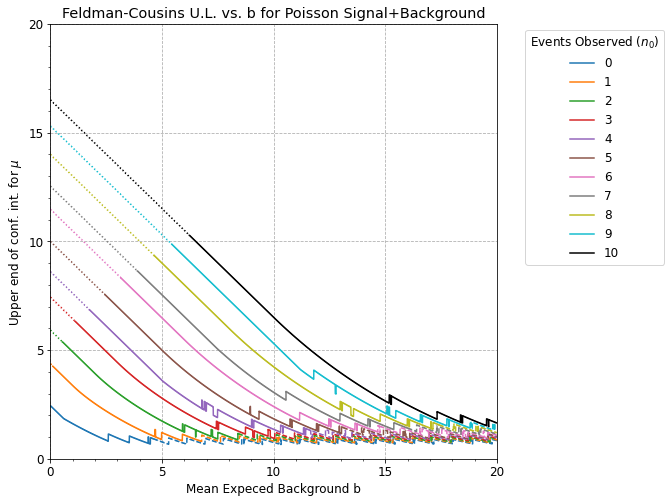

In [503]:
plot_ULs_vs_bg(ns, bs, ULs, LLs, enforce_monotone=False)

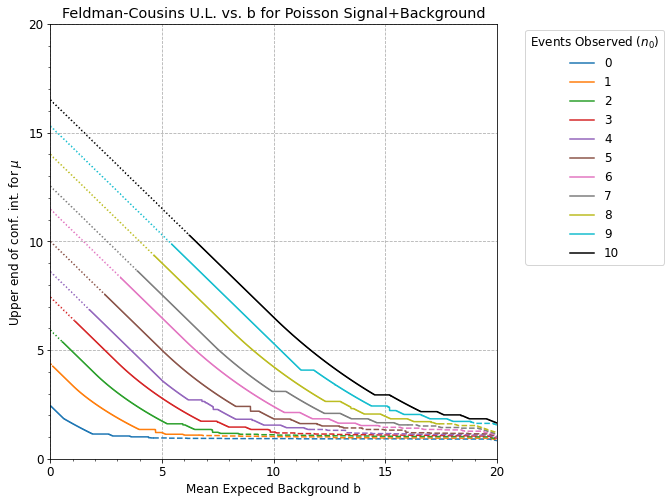

In [504]:
plot_ULs_vs_bg(ns, bs, ULs, LLs, enforce_monotone=True)

- Looks a little better in some place than before, perhaps a little worse in other places.

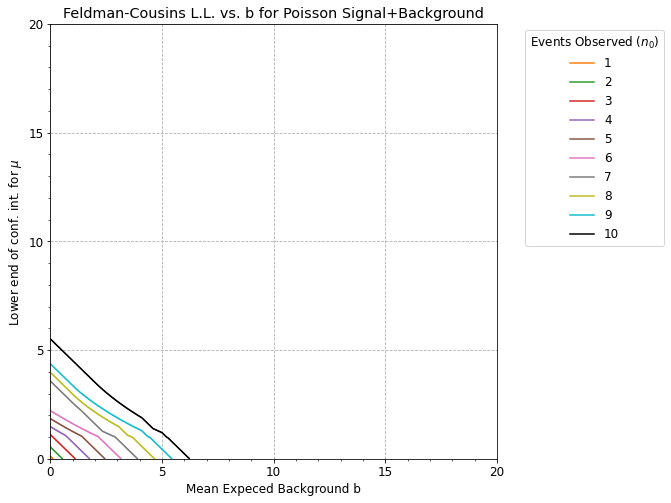

In [505]:
plot_LLs_vs_bg(ns, bs, ULs, LLs, enforce_monotone=False)

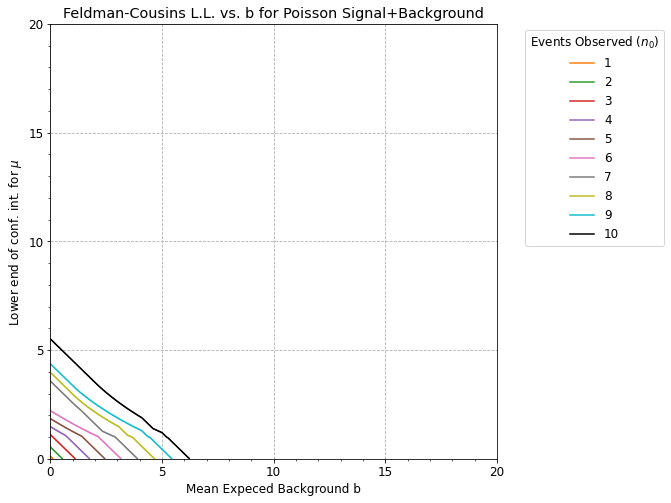

In [506]:
plot_LLs_vs_bg(ns, bs, ULs, LLs, enforce_monotone=True)

- This reproduces Fig. 9. Not sure if monotone condition changes anything in this case. Also not sure if this condition must be enforced for the LL. 

### Reproduce FC Algorithm for Fig. 8 and 9

- **NOTE:** At this point I realized I didn't exactly follow FC prescribed method for finding CLs. They use the following algortithm (which I should try to reproduce, maybe later):
    1. Pick some $b$
    2. Over the $\mu$ range $[0, 50]$, with step size $\Delta \mu = 0.005$, calculate boundaries of CI ($n_1$ and $n_2$)
    3. For each desired measurement $n_0$, pick out CI from this dataset
    4. Repeat 1-3 for all $b$
- The choice of $\Delta \mu = 0.005$ is sufficient for a CI interval accuracy of $0.01$

### Table IV. 90% C.L. intervals for the Poisson signal mean $\mu$, for a total events obvserved $n_0$, for a known mean background $b$ ranging from $0$ to $5$.

In [552]:
# pick most correct function
# using parallel now since it is fast
ns_t4, bs_t4, LLs_t4, ULs_t4 = FC_Poisson_ns_CL_b_range_parallel(ns=np.arange(0,21,1), 
                                                                 bs=np.arange(0,25+0.001, 0.001), alpha=0.9)

Calculating Limits vs. Expected Background
------------------------------------------
CPU Threads: 64



Runtime: 1546.8294169902802 s, 25.780490283171336 min


In [553]:
LLs_t4.shape

(21, 25001)

In [556]:
ULs_t4[-1]

array([28.529, 28.529, 28.529, ...,  4.389,  4.389,  4.389])

In [557]:
# monotonicity
LL_ = deepcopy(LLs_t4)
UL_ = deepcopy(ULs_t4)
for i in range(len(LL_)):
    #LL_[i] = np.maximum.accumulate(LL_[i][::-1])[::-1]
    UL_[i] = np.maximum.accumulate(UL_[i][::-1])[::-1]
LLs_t4_mon = LL_
ULs_t4_mon = UL_

In [562]:
# loop through b
results_dict = {}
results_dict[r'$n_0$'] = ns_t4
for i,b in enumerate(bs_t4):
    if np.isin(b, np.arange(0., 5.5, 0.5)):
        LL_ = LLs_t4_mon[:,i]
        UL_ = ULs_t4_mon[:,i]
        CI_strs = np.array([f'{l:0.2f}, {u:0.2f}' for l,u in zip(LL_, UL_)])
        results_dict[f'{b:0.1f}'] = CI_strs
df_t4 = pd.DataFrame(results_dict)

In [563]:
df_t4

,$n_0$,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
0,0,"0.00, 2.44","0.00, 1.94","0.00, 1.61","0.00, 1.34","0.00, 1.14","0.00, 1.14","0.00, 1.05","0.00, 1.05","0.00, 1.01","0.00, 0.96","0.00, 0.96"
1,1,"0.11, 4.36","0.00, 3.86","0.00, 3.36","0.00, 2.91","0.00, 2.53","0.00, 2.19","0.00, 1.88","0.00, 1.60","0.00, 1.35","0.00, 1.35","0.00, 1.20"
2,2,"0.54, 5.92","0.04, 5.42","0.00, 4.92","0.00, 4.42","0.00, 3.92","0.00, 3.45","0.00, 3.04","0.00, 2.67","0.00, 2.33","0.00, 2.02","0.00, 1.73"
3,3,"1.11, 7.43","0.61, 6.93","0.11, 6.43","0.00, 5.93","0.00, 5.43","0.00, 4.93","0.00, 4.43","0.00, 3.96","0.00, 3.53","0.00, 3.14","0.00, 2.79"
4,4,"1.48, 8.60","1.17, 8.10","0.75, 7.60","0.25, 7.10","0.00, 6.60","0.00, 6.10","0.00, 5.60","0.00, 5.10","0.00, 4.60","0.00, 4.10","0.00, 3.60"
5,5,"1.84, 9.99","1.54, 9.49","1.25, 8.99","0.94, 8.49","0.44, 7.99","0.00, 7.49","0.00, 6.99","0.00, 6.49","0.00, 5.99","0.00, 5.49","0.00, 4.99"
6,6,"2.21, 11.47","1.90, 10.97","1.61, 10.47","1.34, 9.97","1.09, 9.47","0.66, 8.97","0.16, 8.47","0.00, 7.97","0.00, 7.47","0.00, 6.97","0.00, 6.47"
7,7,"3.57, 12.54","3.07, 12.04","2.57, 11.54","2.09, 11.04","1.59, 10.54","1.19, 10.04","0.90, 9.54","0.40, 9.04","0.00, 8.54","0.00, 8.04","0.00, 7.54"
8,8,"3.97, 14.00","3.47, 13.50","2.97, 13.00","2.52, 12.50","2.14, 12.00","1.81, 11.50","1.51, 11.00","1.06, 10.50","0.66, 10.00","0.16, 9.50","0.00, 9.00"
9,9,"4.36, 15.30","3.86, 14.80","3.36, 14.30","2.91, 13.80","2.53, 13.30","2.19, 12.80","1.88, 12.30","1.60, 11.80","1.34, 11.30","0.94, 10.80","0.44, 10.30"


- By eye, this seems to do a pretty good job reproducing Table IV, with the exception of $n_0 =0$ where $b >= 2.0$
- Would be interesting to see again after using FC algorithm. (Later)

## Gaussian with $\mu >= 0$

## Mu2e Sensitivity (out of order)

In [573]:
N = 100000 # ensemble size

In [572]:
mu = 0
b = 0.41

In [575]:
N_ens = np.random.poisson(lam=mu+b, size=N)

In [577]:
N_ens.max()

6

In [579]:
ns_mu2e, LLs_mu2e, ULs_mu2e = FC_Poisson_ns_CL_v2(ns=np.arange(0,8,1), b=0.41, alpha=0.9, eps=0.01)

In [581]:
LLs_mu2e, ULs_mu2e

(array([0.  , 0.  , 0.13, 0.7 , 1.23, 1.59, 1.96, 3.16]),
 array([ 2.029,  3.949,  5.509,  7.019,  8.189,  9.579, 11.059, 12.129]))

In [583]:
ns_mu2e

array([0, 1, 2, 3, 4, 5, 6, 7])

In [585]:
LLs_ens = LLs_mu2e[N_ens]
ULs_ens = ULs_mu2e[N_ens]

In [586]:
np.mean(ULs_ens)

2.784710399999998

In [588]:
np.mean(ULs_ens)+b

3.194710399999998

In [587]:
## THIS IS MU2E SENSITIVITY
mu2e_mu_to_Rmue(mu=2.7871)

8.407541478129714e-17

In [612]:
# median
np.median(ULs_ens)

2.0289999999999986

In [613]:
mu2e_mu_to_Rmue(mu=2.029)

6.120663650075415e-17

In [707]:
### year 1 (2024), 2020-02-13 DiFalco, Murat
b = 0.046
SES = 7.29e-16

In [708]:
#s0 = 6.63; Rmue0 = 2e-16; m = Rmue0/s0
#    Rmue = m * mu
#    return Rmue

In [733]:
N = 100000 # ensemble size
mu = 0
#b = 0.046
b = 0.171
###b = 0.41
rng = np.random.default_rng()
N_ens = rng.poisson(lam=mu+b, size=N)
#N_ens = np.random.poisson(lam=mu+b, size=N)

In [734]:
N_ens.max()

4

In [735]:
ns_mu2e, LLs_mu2e, ULs_mu2e = FC_Poisson_ns_CL_v2(ns=np.arange(0,8,1), b=0.41, alpha=0.9, eps=0.01)
LLs_mu2e, ULs_mu2e

(array([0.  , 0.  , 0.13, 0.7 , 1.23, 1.59, 1.96, 3.16]),
 array([ 2.029,  3.949,  5.509,  7.019,  8.189,  9.579, 11.059, 12.129]))

In [736]:
LLs_ens = LLs_mu2e[N_ens]
ULs_ens = ULs_mu2e[N_ens]

In [737]:
np.mean(ULs_ens)

2.3572394999999986

In [727]:
np.mean(ULs_ens) * SES

1.5427350962999992e-15

In [739]:
poisson.ppf(alpha, mu=0.046), poisson.ppf(alpha, mu=0.125), poisson.ppf(alpha, mu=0.171)

(3.0, 4.0, 5.0)

In [ ]:
## 5 sigma from FC plot

In [749]:
alpha = 1-norm.sf(5, loc=0, scale=1)
alpha

0.9999997133484281

In [750]:
FC_Poisson_Acceptance(mu=0,b=0.41, alpha=alpha)

(0, 6)

In [742]:
ns_, LL_, UL_ = FC_Poisson_ns_CL(ns=np.linspace(0,1,1), b=0.41, alpha=alpha)

In [ ]:
FC_Poisson_Construct_Plot(b=0.41, alpha=alpha)

In [ ]:
## 5 sigma discovery

In [654]:
alpha = 1 - norm.sf(5, loc=0, scale=1) # one sided
#alpha = 1 - 2*norm.sf(5, loc=0, scale=1) # two sided

In [655]:
alpha

0.9999997133484281

In [656]:
poisson.isf(1-alpha, mu=b)

6.0

In [657]:
poisson.ppf(alpha, mu=b)

6.0

In [658]:
1-alpha

2.866515719235352e-07

In [659]:
1-poisson.cdf(6, mu=b)

2.702129544562837e-07

In [677]:
1-(poisson.cdf(5, mu=b) + .996* poisson.pmf(6, mu=b))

2.8772633153817395e-07

In [660]:
1-(poisson.cdf(6, mu=b) + 0.3*poisson.pmf(7, mu=b))

1.932791909853293e-07

In [653]:
norm.sf(5, loc=0, scale=1)

2.866515718791933e-07

In [633]:
2*norm.sf(5, loc=0, scale=1)

5.733031437583866e-07

In [627]:
norm.sf(5, loc=0, scale=1)

2.866515718791933e-07

In [ ]:
.3

In [602]:
mu2e_mu_to_Rmue(mu=6.3)

1.900452488687783e-16

In [603]:
mu2e_mu_to_Rmue(mu=6)

1.8099547511312217e-16

In [622]:
6.6 * 3.0143e-17

1.9894379999999997e-16

In [ ]:
######

In [686]:
b = 0.41
ns = np.arange(b,10,0.001)
zs = (2*(ns * np.log(ns/b) + b - ns))**(1/2)

In [687]:
zs

array([0.00000000e+00, 1.56110341e-03, 3.12094097e-03, ...,
       6.68464659e+00, 6.68512438e+00, 6.68560214e+00])

In [692]:
idx_min = np.argmin(np.abs(zs-5))
idx_min

6316

In [693]:
ns[idx_min], zs[idx_min]

(6.726000000000006, 5.00010291003698)

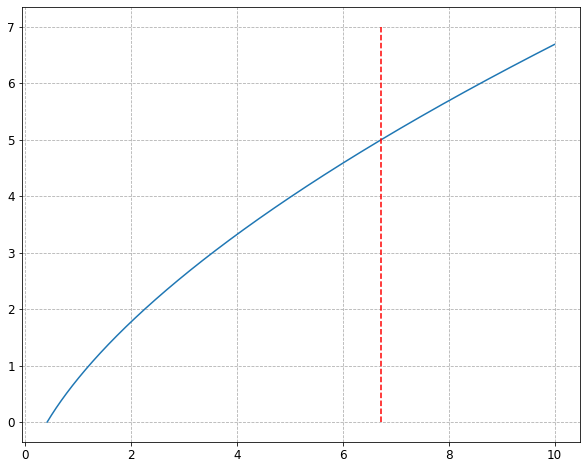

In [696]:
plt.figure()
plt.plot(ns,zs)
plt.plot([ns[idx_min], ns[idx_min]],[0,7],'r--')

In [702]:
1-alpha

2.866515719235352e-07

In [705]:
1-(poisson.cdf(5, mu=b) + .726*poisson.pmf(6,mu=b))

1.4698792818457207e-06

In [704]:
1-poisson.cdf(6, mu=b)

2.702129544562837e-07

In [703]:
1-poisson.cdf(6.726, mu=b)

2.702129544562837e-07

In [697]:
mu2e_mu_to_Rmue(6.726)

2.0289592760180997e-16

In [700]:
mu2e_mu_to_Rmue(6.3)

1.900452488687783e-16

# Etc.

## Gaussian Confidence Belts

- Reproducing plots from Section IIIa. Gaussian with a boundary at the origin
- $\mu >= 0;\ \sigma=1$
- Trying out `isf` and `ppf` here

In [24]:
# this should be it
alpha=0.9
mu= 10
sigma=1
# UL
x1_UL = norm.ppf(1-alpha, loc=mu, scale=sigma)
x1, x2 = norm.ppf((1-alpha)/2, loc=mu, scale=sigma), norm.isf((1-alpha)/2, loc=mu, scale=sigma)

In [25]:
x1_UL, x1,x2

(8.7184484344554, 8.355146373048527, 11.644853626951473)

### Upper Limit

In [26]:
def gaussian_classical_UL(mu_t=0, sigma=1, alpha=0.9):
    # returns x1 that defines minimum x0 for which this particular mu_t is in CL
    x1 = norm.ppf(1-alpha, loc=mu_t, scale=sigma)
    return x1

In [27]:
gaussian_classical_UL(mu_t=5)

3.7184484344553996

In [28]:
norm.sf(3.71844843, loc=5, scale=1)

0.9000000007819151

In [29]:
def gaussian_classical_UL_plot(mus=np.linspace(0,6,601), sigma=1.0, alpha=0.9, x0=2, xlims=[-2,4], ylims=[0,6]):
    # calculates entire UL for gaussian and plots
    
    # calculate x1 for all mus
    x1s = []
    for mu in mus:
        x1s.append(gaussian_classical_UL(mu_t=mu, sigma=sigma, alpha=alpha))
    x1s = np.array(x1s)
    
    # for example x0, find UL
    idx = (np.abs(x0-x1s)).argmin()
    x0_UL = np.max(mus[x1s==x1s[idx]])
    
    # plot!
    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(x1s, mus, linewidth=2, label=f'Reported U.L., {alpha*100:.1f}% C.L.')
    #ax.fill_betweenx(y1s, x1s, 1.5*xlims[1]*np.ones_like(y1s), label=rf'$\mu$ for which $n_0$ occurs in $\alpha={{alpha}}$ fraction of Experiments')
    ax.fill_betweenx(mus, x1s, 1.5*xlims[1]*np.ones_like(mus), alpha=0.3)#, label=rf'$\mu$ s.t. {alpha*100:.1f}% Experiments for which $n_0$ occurs in $\alpha={{alpha}}$ fraction of Experiments')
    ax.plot([x0,x0], ylims, 'g--', label=rf'Particular Experiment: $x_0={x0}, \mu_{{\mathrm{{U.L.}}}}={x0_UL:.2f}$')
    # fix tick locations and axis ranges
    ax.set_xticks(np.arange(xlims[0], xlims[1]+1, 1))
    ax.set_yticks(np.arange(ylims[0], ylims[1]+1, 1))
    ax.xaxis.set_minor_locator(MultipleLocator(0.2))
    ax.yaxis.set_minor_locator(MultipleLocator(0.2))
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    # add labels
    ax.set_xlabel(r'Measured Mean $x$')
    ax.set_ylabel(r'Mean $\mu$')
    ax.set_title(rf'Classical C.L. for Gaussian Process (Upper Limit), $\alpha={alpha},\ \sigma={sigma}$')
    ax.legend()
    
    return fig, ax, mus, x1s

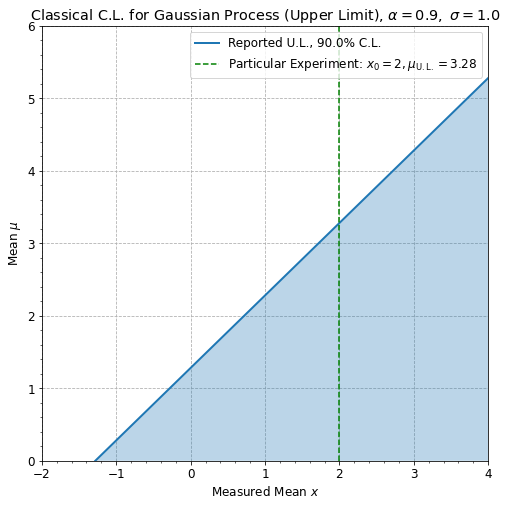

In [30]:
fig, ax, mus, x1s = gaussian_classical_UL_plot()

- This reproduces Fig. 2

### Central Intervals

In [31]:
def gaussian_classical_central(mu_t=0, sigma=1.0, alpha=0.9):
    # returns x1, x2 that defines central acceptance region for this particular mu_t is in CL
    
    x1 = norm.ppf((1-alpha)/2, loc=mu_t, scale=sigma)
    x2 = norm.isf((1-alpha)/2, loc=mu_t, scale=sigma)
    
    return x1, x2

In [32]:
x1, x2 = gaussian_classical_central(mu_t=2)
x1, x2

(0.35514637304852714, 3.644853626951473)

In [33]:
norm.cdf(x2, loc=2, scale=1)-norm.cdf(x1, loc=2, scale=1)

0.9000000000000001

In [34]:
#def poisson_classical_UL_plot(mus=np.linspace(0,15,151), b=3.0, alpha=0.9, n0=6, xlims=[0,15], ylims=[0,15]):
def gaussian_classical_central_plot(mus=np.linspace(0,6,1201), sigma=1.0, alpha=0.9, x0=2, xlims=[-2,4], ylims=[0,6]):
    # calculates entire UL for gaussian process and plots
    
    # calculate x1 for all mus
    x1s = []
    x2s = []
    for mu in mus:
        x1_, x2_ = gaussian_classical_central(mu_t=mu, sigma=sigma, alpha=alpha)
        x1s.append(x1_)
        x2s.append(x2_)
    x1s = np.array(x1s)
    x2s = np.array(x2s)
    
    # for example n0, find UL
    idx1 = (np.abs(x0-x1s)).argmin()
    idx2 = (np.abs(x0-x2s)).argmin()
    
    if (x2s==x2s[idx2]).sum() < 1:
        x0_CL0 = 0
    else:
        x0_CL0 = np.min(mus[x2s==x2s[idx2]])
    x0_CL1 = np.max(mus[x1s==x1s[idx1]])
    
    # plot!
    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(x1s, mus, color='blue', linewidth=2, )#label=f'Reported U.L., {alpha*100:.1f}% C.L.')
    ax.plot(x2s, mus, color='blue', linewidth=2, )
    #ax.fill_betweenx(y1s, x1s, 1.5*xlims[1]*np.ones_like(y1s), label=rf'$\mu$ for which $n_0$ occurs in $\alpha={{alpha}}$ fraction of Experiments')
    ax.fill_betweenx(mus, x1s, x2s, alpha=0.3, label=f'{alpha*100:.1f}% C.I.')#, label=rf'$\mu$ s.t. {alpha*100:.1f}% Experiments for which $n_0$ occurs in $\alpha={{alpha}}$ fraction of Experiments')
    ax.plot([x0,x0], ylims, 'g--', label=rf'Particular Experiment: $x_0={x0}, \mu_{{\ \mathrm{{C.I.}}}}=[{x0_CL0}, {x0_CL1}]$')
    # fix tick locations and axis ranges
    ax.set_xticks(np.arange(xlims[0], xlims[1]+1, 1))
    ax.set_yticks(np.arange(ylims[0], ylims[1]+1, 1))
    ax.xaxis.set_minor_locator(MultipleLocator(0.2))
    ax.yaxis.set_minor_locator(MultipleLocator(0.2))
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    # add labels
    ax.set_xlabel(r'Measured Mean $x$')
    ax.set_ylabel(r'Mean $\mu$')
    ax.set_title(rf'Classical C.L. for Gaussian Process (Central Interval), $\alpha={alpha},\ \sigma={sigma}$')
    ax.legend()
    
    return fig, ax, mus, x1s, x2s

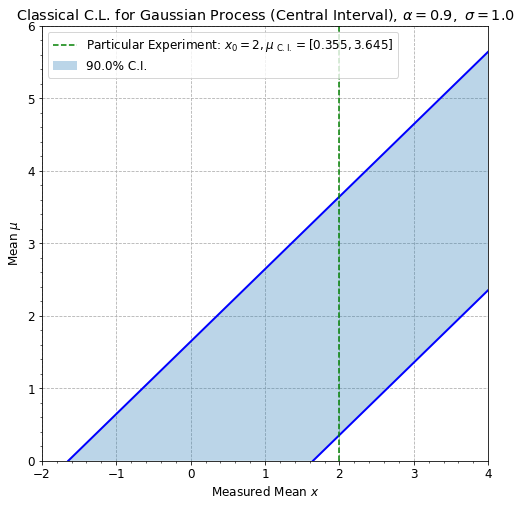

In [35]:
fig, ax, mus, x1s, x2s = gaussian_classical_central_plot(x0=2)

- This reproduces Fig. 3

In [36]:
(3.645-.355)/2

1.645

In [37]:
(1-norm.cdf(1.645, loc=0, scale=1))*2

0.09996981107824277

### Gaussian Flip-Flop

- In Section IIIa.
- "physicist X":
    - if $x_0 < 0$, pretend $x_0 = 0$
    - if $x_0 < 3\sigma$ (i.e. $x_0 < 3$ for $\sigma = 1$), quote an "upper limit"
    - if $x_0 >= 3$, quote a "central confidence interval"
- **THIS IS BAD. SEVERE UNDERCOVERAGE IN $1.36 < \mu < 4.28$, AND OVERCOVERAGE IN APPROX. $\mu < 1.25$**

In [38]:
def bad_gaussian_flipflop():
    mus = np.linspace(0, 6, 1201); sigma=1; alpha=0.9
    xlims=[-2,4]; ylims=[0,6]
    fig, ax, mus_UL, x1_UL = gaussian_classical_UL_plot(mus, sigma=sigma, alpha=alpha, x0=2);
    fig, ax, mus_CI, x1_CI, x2_CI = gaussian_classical_central_plot(mus, sigma=sigma, alpha=alpha, x0=2);
    
    # segment 1 (x1, x<0, horizontal chunk)
    idx_neg = x1_UL[x1_UL<=0].argmax()
    seg1x1 = x1_UL[:idx_neg+1]
    seg1y1 = mus_UL[idx_neg+1]*np.ones_like(seg1x1)
    # segment 2 (x1, UL)
    idx_pos = np.argmax(x1_UL[x1_UL <= 3])
    seg2x1 = x1_UL[idx_neg+1:idx_pos+1]
    seg2y1 = mus_UL[idx_neg+1:idx_pos+1]
    # seg 3 (x1, CI)
    idx_CI = np.where(x1_CI >= 3)[0][0]
    seg3x1 = x1_CI[idx_CI:]
    seg3y1 = mus_CI[idx_CI:]
    # segment 1 (x2, all zero)
    idx2 = np.where(x2_CI<=3)[0][-1]
    seg1x2 = x2_CI[:idx2+1]
    seg1y2 = np.zeros_like(seg1x2)
    # segment 2 (x2, CI)
    seg2x2 = x2_CI[idx2+1:]
    seg2y2 = mus_CI[idx2+1:]

    # concatenate
    x1s = np.concatenate([seg1x1, seg2x1, seg3x1])
    y1s = np.concatenate([seg1y1, seg2y1, seg3y1])
    x2s = np.concatenate([seg1x2, seg2x2])
    y2s = np.concatenate([seg1y2, seg2y2])
    
    # plot
    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(x1s, y1s, color='blue', linewidth=2, )#label=f'Reported U.L., {alpha*100:.1f}% C.L.')
    ax.plot(x2s, y2s, color='blue', linewidth=2, )
    #ax.fill_betweenx(y1s, x1s, 1.5*xlims[1]*np.ones_like(y1s), label=rf'$\mu$ for which $n_0$ occurs in $\alpha={{alpha}}$ fraction of Experiments')
    #ax.fill_betweenx(mus, x1s, x2s, alpha=0.3, label=f'{alpha*100:.1f}% C.I.')#, label=rf'$\mu$ s.t. {alpha*100:.1f}% Experiments for which $n_0$ occurs in $\alpha={{alpha}}$ fraction of Experiments')
    #ax.plot([x0,x0], ylims, 'g--', label=rf'Particular Experiment: $x_0={x0}, \mu_{{\ \mathrm{{C.I.}}}}=[{x0_CL0}, {x0_CL1}]$')
    # fix tick locations and axis ranges
    ax.set_xticks(np.arange(xlims[0], xlims[1]+1, 1))
    ax.set_yticks(np.arange(ylims[0], ylims[1]+1, 1))
    ax.xaxis.set_minor_locator(MultipleLocator(0.2))
    ax.yaxis.set_minor_locator(MultipleLocator(0.2))
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    # add labels
    ax.set_xlabel(r'Measured Mean $x$')
    ax.set_ylabel(r'Mean $\mu$')
    ax.set_title(rf'Flip-Flop C.L. for Gaussian Process, $\alpha={alpha},\ \sigma={sigma}$')
    #ax.legend()
    
    #return fig, ax, mus, x1s, x2s
    return fig, ax, x1s, x2s, y1s, y2s, mus_UL, mus_CI, x1_UL, x1_CI, x2_CI

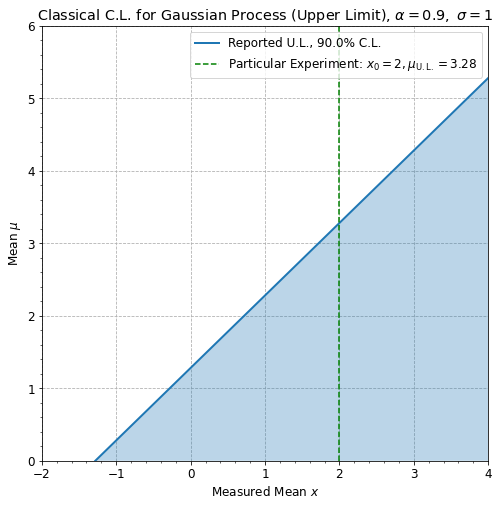

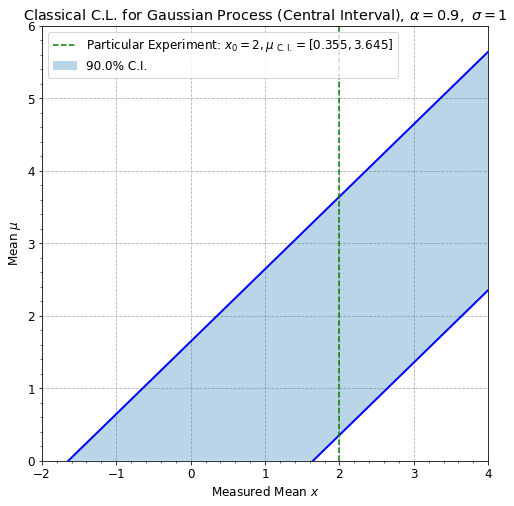

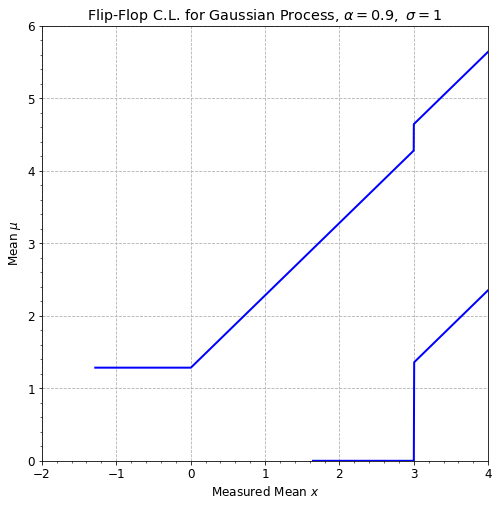

In [39]:
bad_gaussian_flipflop();

- This coarsely reproduces Fig. 4. Not spending more time to make it look nice since this is bad!